In [50]:
# import libraries
import pandas as pd
import numpy as np
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import plotly.graph_objects as go
from tqdm import tqdm

In [45]:
sns.set(style="white")
my_map = sns.light_palette("seagreen", as_cmap=True)

In [53]:
# load the datasets
td_dataset = pd.read_stata("data/td_ita.dta")  # time diaries dataset
demo_dataset = pd.read_stata("data/data4diarynew_ITA.dta") # demographics dataset
step_dataset = pd.read_csv("data/stepDetector_30min.csv") # step counter dataset

In [60]:
td_dataset
results = td_dataset.copy()
results = results.drop('pilot', axis=1)

In [61]:
results = results.rename(columns={'DD_not': 'day'})

In [62]:
IDs= pd.array(results.id.unique())
# maja_id is the list of all the users who did sport once
maja_id = pd.array([0, 1, 2, 4, 5, 6, 9, 10, 12, 15, 17, 19, 21, 22, 23, 24, 26, 27, 31, 32, 33, 37, 41, 43, 44, 45, 48, 53, 57, 58, 60, 61, 63, 66, 67, 68, 72, 73, 74, 75, 76, 77, 80, 82, 83, 84, 85, 87, 89, 92, 95, 97, 98, 99, 100, 103, 105, 106, 109, 112, 113, 114, 118, 119, 120, 123, 125, 127, 128, 130, 131, 134, 136, 137, 141, 146, 148, 149, 151, 153, 155, 160, 163, 164, 167, 169, 172, 177, 182, 185, 190, 199, 202, 204, 205, 206, 207, 213, 214, 215, 216, 218, 219, 220, 222, 223, 227, 228, 229, 231, 232, 233, 238, 239, 240, 242, 243, 244, 245, 250, 251, 254, 255, 256, 258, 260, 262, 265, 266])
IDs = IDs[IDs.isin(maja_id)]
user_activity = dict()
for ID in tqdm(IDs):
    
    id_act = results[results.id == ID]
    # adding to the dictionary
    user_activity[f'{ID}'] = pd.Series(id_act.day.unique()).sort_values()

print('N:',len(user_activity.keys())) 
print("Done!")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 129/129 [00:01<00:00, 112.24it/s]

N: 129
Done!


In [64]:
def gantt_data_org(k, v):
    
    #gantt data is named after the Gantt chart, although it's not present here
    #S is the Series of days; it's best if it's a consecutive 14 days (regardless of when they start)
    
    tot = 0
    start = np.nan
    end = np.nan
    consecutive = False
    
    if len(v):  #if it's not empty, it will check for continuity
        tot = (pd.to_datetime(v[-1]) - pd.to_datetime(v[0])).days
        start, end = v[0], v[-1]
        for i in range(len(v)-1):
            v[i]  #current
            v[i+1] #next
            difference = (pd.to_datetime(v[i+1]) - pd.to_datetime(v[i])).days
            if difference >= 2:    # if there is more than one day of difference it means that there was one 
                                   # day in the data with no observations
                consecutive = False
                break
            else:
                consecutive = True
                
    return pd.DataFrame([[k, start, end, tot, consecutive]], 
                        columns=['userid', 'start', 'finish', 'tot', 'cons'])

#example of output:
gantt_data_org(1, ["2020-11-12", "2020-11-13", "2020-11-14", "2020-11-15", "2020-11-16", 
                   "2020-11-17",   "2020-11-18", "2020-11-19", "2020-11-25"])
gantt_data = pd.DataFrame(columns=["id", "start", "finish", "tot", "cons"])


for ID, days in user_activity.items():
    res = gantt_data_org(ID, days.tolist())
    gantt_data = pd.concat([gantt_data, res], ignore_index=True)

/tmp/ipykernel_6803/2076389757.py:36: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  gantt_data = pd.concat([gantt_data, res], ignore_index=True)
/tmp/ipykernel_6803/2076389757.py:36: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  gantt_data = pd.concat([gantt_data, res], ignore_index=True)
/tmp/ipykernel_6803/2076389757.py:36: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  gantt_data = pd.concat([gantt_data, res], ignore_index=True)
/tmp/ipykernel_6803/2076389757.py:36: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explic

In [71]:
gantt_data[gantt_data['cons'] == False]

,id,start,finish,tot,cons,userid


## Cleaning procedure of the time diaries dataset
We need to apply two steps:
1. consider only first two weeks of the survey
2. consider only the answers in which the users declared they are were doing any kind of sport activity

In [56]:
td_cleaned = td_dataset[td_dataset['first2w'] == 'First two weeks']
td_cleaned = td_cleaned[(td_cleaned["what"]=="Sport") | (td_cleaned["what"]=="I will participate in sports activities") |(td_cleaned["what"]=="Walking")]

## Variable transformation
New variables we want to analyze are:
- the duration of the sport activity
- the location of the sport activity considering if the users is in 'private' space (indoor) or in public space (outdoor)
- with who the user is practicing sport: if alone or in company
- the type of sport activity the user is practicing

In [57]:
# duration of sport activity variable
new_td = td_cleaned
new_td['date_not'] = pd.to_datetime(new_td['date_not'])
new_td['date_dur'] = new_td['date_not'] - timedelta(hours = 5)

new_td = new_td .sort_values('date_dur') # sort the dataframe according to "date_dur"
new_td['time_diff'] = new_td['date_dur'].diff() # compute the time difference between adjacent rows

new_session = (new_td['time_diff'] > pd.Timedelta(minutes=30)) | new_td['time_diff'].isnull() # search for new start session
new_td['session'] = new_session.cumsum() # Creazione di un nuovo identificatore di sessione basato su new_session

collapsed_sessions = new_td.groupby(['id', 'session']).agg(
    start_time=('date_not', 'first'),
    end_time=('date_not', 'last'),
    duration=('date_dur', lambda x: ((x.max() - x.min()).total_seconds() / 60)+30)
).reset_index()

collapsed_sessions = collapsed_sessions.drop(columns='session')

# merge the two datasets
td_cleaned = td_cleaned.merge(collapsed_sessions, left_on=['id', 'date_not'], right_on=['id', 'start_time']) # inner join of the two datasets

### Data cleaning
After computing the duration of the sport session we need to apply two mpre data cleaning steps:
1. we want to eliminate the sport session in which the type of sport is Walking and the duration is 30 minutes because we cannot guarantee that the user is doing sport but maybe is just walking to go somewhere.
2. we want also to eliminate the sport sessions in which the type of spert is Walking and the location is the university or grocery shops. In such cases the probability that the user is just walking is higher than the probability that the user is doing sport nearby these places.

In [58]:
print(f"Initial number of cases: {td_cleaned.shape[0]}")

# obtain the indexes of the rows satisfying condition 1
to_remove1 = list(td_cleaned[(td_cleaned['what']=='Walking') & (td_cleaned['duration']==30.0)].index)

# remove these cases
td_cleaned = td_cleaned.drop(index=to_remove1)
print(f"Number of cases after first cleaning: {td_cleaned.shape[0]}")

# obtain the indexes of the rows satisfying condition 2
places = [ 'Supermarket …', 'Street markets', 'Grocery Shop', 'University Library', 'Other university place']
to_remove2 = list(td_cleaned[(td_cleaned['what']=='Walking') & (td_cleaned['where'].isin(places))].index)

# remove these cases
td_cleaned = td_cleaned.drop(index=to_remove2)
print(f"Number of cases after second cleaning: {td_cleaned.shape[0]}")

Initial number of cases: 1325
Number of cases after first cleaning: 1044
Number of cases after second cleaning: 1033


In [59]:
# location of sport activity variable
td_cleaned['where recoded'] = td_cleaned['where'].replace(['Home apartment /room', 'Weekend home or holiday apartment', 'House (friends others)', 'Relatives Home', 'Home garden/patio/courtyard',
                                                           'Another indoor place', 'Gym, swimming pool, Sports centre …', 'Other university place', 'Countryside/mountain/hill/beach', 'In the street', 'Another outdoor place', 'Café, pub, bar', 'Shops, shopping centres', 'Not answer'],
                                                          ['indoor', 'indoor', 'indoor', 'indoor', 'indoor',
                                                           'outdoor', 'outdoor', 'outdoor', 'outdoor', 'outdoor', 'outdoor', 'outdoor', 'outdoor', 'not specified'])
td_cleaned['where recoded'] = td_cleaned['where recoded'].cat.remove_unused_categories()

In [60]:
# company during sport activity variable
td_cleaned['withw recoded'] = td_cleaned['withw'].replace(['Partner', 'Friend(s)', 'Relative(s)', 'Roommate(s)', 'Other', 'Colleague(s)',
                                                           'Classmate(s)',
                                                           'Alone',
                                                           'Not answer'],
                                                          ['company', 'company', 'company', 'company', 'company', 'company', 'company',
                                                           'alone',
                                                           'not specified'])

td_cleaned['withw recoded'] = td_cleaned['withw recoded'].cat.remove_unused_categories()

In [61]:
# type of sport activity variable
td_cleaned['sport recoded'] = td_cleaned['sport'].replace(['Walking, Trekking, and hiking',
                                                           'Jogging and running',
                                                           'Cycling, skiing, and skating', 'Ball games', 'Other outdoor activities',
                                                           'Gymnastics and fitness',
                                                           'Water sports', 'Other indoor activities'
                                                           ],
                                                          ['Walking, Trekking, and hiking',
                                                           'Jogging and running',
                                                           'Outdoor activities', 'Outdoor activities', 'Outdoor activities',
                                                           'Gymnastics and fitness',
                                                           'Other indoor activities', 'Other indoor activities'
                                                           ])

# adding the category Walking to the sport activity
td_cleaned['sport recoded'] = td_cleaned['sport recoded'].cat.add_categories('Walking')
td_cleaned.loc[td_cleaned['what'] == 'Walking', 'sport recoded'] = 'Walking'

td_cleaned['sport recoded'] = td_cleaned['sport recoded'].cat.remove_unused_categories()

In [62]:
# useful conversions
td_cleaned['id'] = td_cleaned['id'].astype(int)
demo_dataset['userid'] = demo_dataset['userid'].astype(int)
td_cleaned['hours'] = td_cleaned['date_not'].dt.hour

In [63]:
new_dataset = td_cleaned.copy()
new_dataset = new_dataset[['id', 'start_time', 'week', 'DD_not', 'hh_not', 'sport recoded', 'duration', 'where recoded', 'withw recoded']]
cat_dataset = new_dataset.merge(demo_dataset, left_on='id', right_on='userid', how='left')

In [64]:
cat_dataset = cat_dataset[[ 'sport recoded', 'where recoded', 'withw recoded','degree', 'Dep_UNITN', 'w1_A01']]
cat_dataset.columns = ['type of activity', 'location', 'company', 'degree', 'department',  'sex']

## data analysis (part 1)
We first want to see the possible relation between the variables referring to the sport sessions
The statics we implemented are:
- chi-squared statistic test
- Cramer's V statistics: this value ranges from 0 to 1, with 0 indicating no association between the variables and 1 indicating a strong association between the variables.

In [65]:
# chi-squared statistic test
def chi_calculate(df):
    factors_paired = [(i,j) for i in df.columns.values for j in df.columns.values]
    chi2 = []
    p_values = []

    for f in factors_paired:
        if f[0] != f[1]:
            current_data = np.array(pd.crosstab(df[f[0]], df[f[1]]))
            chitest = chi2_contingency(current_data)

            chi2.append(chitest[0])
            p_values.append(chitest[1])

        else:
            chi2.append(0)# for same factor pair
            p_values.append(0)

    # create a dataframe for chi-squared test
    chi2 = np.array(chi2).reshape((len(df.columns),len(df.columns))) # shape it as a matrix
    chi2 = pd.DataFrame(chi2, index=df.columns.values, columns=df.columns.values) # then a df for convenience

    # create a dataframe for p-values associated to chi-squared test
    p_values = np.array(p_values).reshape((len(df.columns),len(df.columns))) # shape it as a matrix
    p_values = pd.DataFrame(p_values, index=df.columns.values, columns=df.columns.values) # then a df for convenience

    return chi2, p_values


chi2_matrix, pvalue_matrix = chi_calculate(cat_dataset)

In [66]:
chi2_matrix

,type of activity,location,company,degree,department,sex
type of activity,0.000000,808.194365,166.744400,17.498104,120.377666,24.716043
location,808.194365,0.000000,1206.153956,2.151521,29.201671,3.177341
company,166.744400,1206.153956,0.000000,1.528707,41.059383,5.677195
degree,17.498104,2.151521,1.528707,0.000000,133.075284,6.609204
department,120.377666,29.201671,41.059383,133.075284,0.000000,215.647758
sex,24.716043,3.177341,5.677195,6.609204,215.647758,0.000000


In [67]:
pvalue_matrix

,type of activity,location,company,degree,department,sex
type of activity,0.000000e+00,1.952213e-172,3.610765e-34,3.645880e-03,5.574855e-10,1.580694e-04
location,1.952213e-172,0.000000e+00,7.380547e-260,3.410382e-01,2.261120e-02,2.041969e-01
company,3.610765e-34,7.380547e-260,0.000000e+00,4.656350e-01,5.441828e-04,5.850767e-02
degree,3.645880e-03,3.410382e-01,4.656350e-01,0.000000e+00,6.513944e-25,1.014530e-02
department,5.574855e-10,2.261120e-02,5.441828e-04,6.513944e-25,0.000000e+00,3.197542e-42
sex,1.580694e-04,2.041969e-01,5.850767e-02,1.014530e-02,3.197542e-42,0.000000e+00


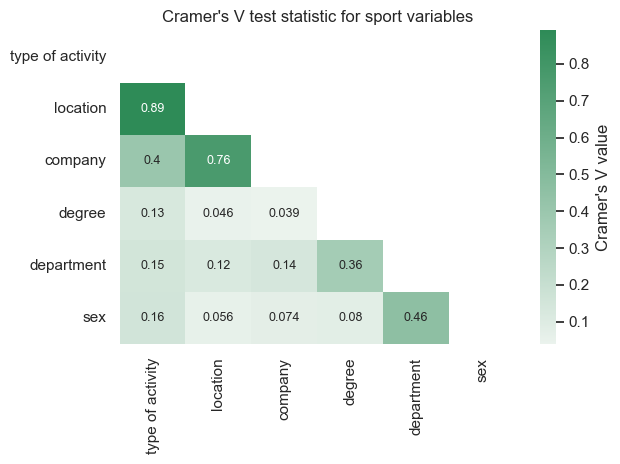

In [68]:
# Cramer's V test
def cr_calculate(df):
    factors_paired = [(i,j) for i in df.columns.values for j in df.columns.values]
    Cramer_V =[]

    for f in factors_paired:
        if f[0] != f[1]:
            current_data = np.array(pd.crosstab(df[f[0]], df[f[1]]))
            chitest = chi2_contingency(current_data)
            n = np.sum(current_data)
            minDim = min(current_data.shape)-1

            #calculate Cramer's V
            V_value = np.sqrt((chitest[0]/n) / minDim)
            Cramer_V.append(V_value)

        else:      # for same factor pair
            Cramer_V.append(0)

    Cramer_V = np.array(Cramer_V).reshape((len(df.columns),len(df.columns))) # shape it as a matrix
    Cramer_V = pd.DataFrame(Cramer_V, index=df.columns.values, columns=df.columns.values) # then a df for convenience
    half_CramerV = np.triu(np.ones_like(Cramer_V))

    # correlation matrix heatmap
    sns.heatmap(Cramer_V, annot=True, annot_kws={'size': 9},
                cbar_kws={'label': "Cramer's V value"},
                mask=half_CramerV,
                cmap=my_map)
    plt.title("Cramer's V test statistic for sport variables")
    plt.tight_layout()
    plt.show()

cr_calculate(cat_dataset)

It appears that there some strong correlation between:
- the location where the users practice sport and the type of activity,
- the location where the users practice sport and the company during the sport session,
- the type of activity practiced during the sport session and the company during the sport session.
Therefore we want to investigate these hypothetical relationships.

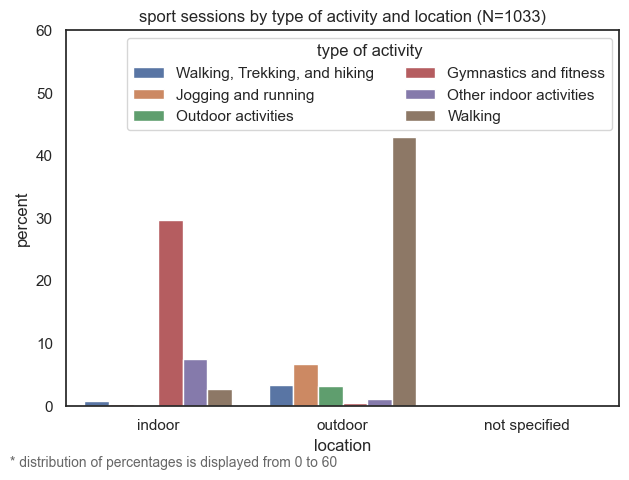

In [69]:
# the location where the users practice sport and the type of activity
sns.countplot(data=cat_dataset, x="location", hue="type of activity", stat="percent")
plt.title(f'sport sessions by type of activity and location (N={cat_dataset.shape[0]})')
plt.tight_layout()
plt.yticks(range(0, 61, 10))
plt.legend(title='type of activity', loc='upper right', ncol=2)
plt.figtext(x=0.02, y=0.01, s="* distribution of percentages is displayed from 0 to 60",
            alpha=0.7, fontsize='small')

plt.show()


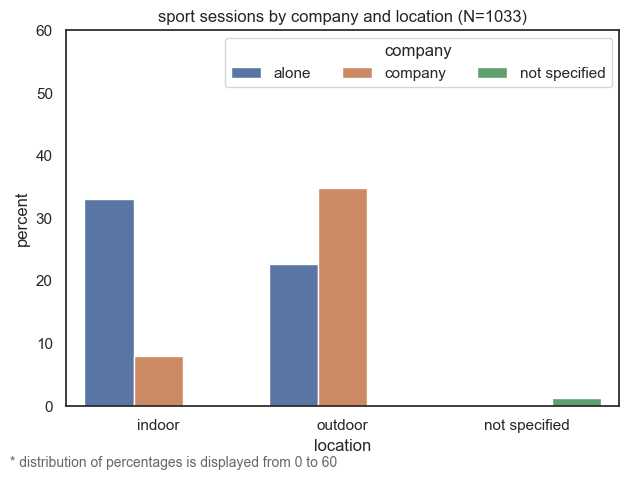

In [70]:
# the location where the users practice sport and the company during the sport session
sns.countplot(data=cat_dataset, x="location", hue="company", stat="percent")
plt.title(f'sport sessions by company and location (N={cat_dataset.shape[0]})')
plt.tight_layout()
plt.yticks(range(0, 61, 10))
plt.legend(title='company', loc='upper right', ncol=3)
plt.figtext(x=0.02, y=0.01, s="* distribution of percentages is displayed from 0 to 60",
            alpha=0.7, fontsize='small')
plt.show()

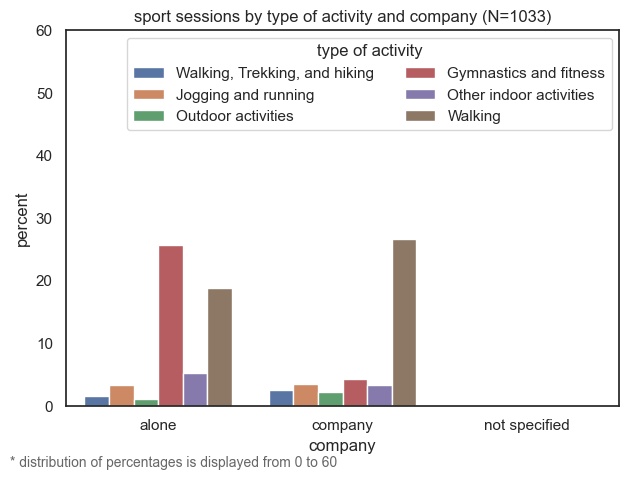

In [71]:
# the type of activity practiced during the sport session and the company during the sport session
sns.countplot(data=cat_dataset, x="company", hue="type of activity", stat="percent")
plt.title(f'sport sessions by type of activity and company (N={cat_dataset.shape[0]})')
plt.tight_layout()
plt.yticks(range(0, 61, 10))
plt.legend(title='type of activity', loc='upper right', ncol=2)
plt.figtext(x=0.02, y=0.01, s="* distribution of percentages is displayed from 0 to 60",
            alpha=0.7, fontsize='small')
plt.show()

## data analysis (part 2)
we now want to see the differences in sociodemographic features of active and inactive users considering sport session and the step counter sensor. To do we need to define users as active or inactive according to:
- sport session: if the user practiced sport at least one time in the two weeks, is defined as active, otherwise as inactive.
- step counter median: if the median of daily steps of the user is higher than the general median then the user is defined as active, otherwise as inactive.

In [72]:
# pre-processing for the sport dataset
sport_activity_data = {'userid': pd.Series(list(td_cleaned['id'].unique())),
                       'sport activity': np.array('active')}

sport_activity_df = pd.DataFrame(sport_activity_data)

In [73]:
# pre-processing for the step dataset
ids = step_dataset['userid'].unique()
step_dataset = step_dataset.drop("Unnamed: 0", axis=1)

# step count
df = step_dataset.copy()
daily_step_counts = df.groupby(['userid', 'day'])['step_count'].sum().reset_index()

media_passi_giornalieri = daily_step_counts['step_count'].mean()
mediana_passi_giornalieri = daily_step_counts['step_count'].median()
#print(f"the median of daily steps is: {mediana_passi_giornalieri}")

step_activity_df = daily_step_counts.groupby('userid')['step_count'].sum().reset_index().rename(columns={'step_count': 'totale_passi_giornalieri'})

step_activity_df['step activity'] = pd.qcut(step_activity_df['totale_passi_giornalieri'], q=[0, 1/3, 2/3, 1], labels=['not very active', 'active', 'very active'])

In [74]:
# merge the demo dataset with the step activity dataset
demo_dataset['userid'] = pd.to_numeric(demo_dataset['userid'])
dataset = demo_dataset.merge(step_activity_df, right_on="userid", left_on="userid", how="left")

# merge the dataset with the sport activity dataset
complete_dataset = dataset.merge(sport_activity_df, right_on="userid", left_on="userid", how="left")

In [75]:
# step activity reclassification:
# we already know active and inactive users, so we do not have information on those users who didn't have the sensor on
complete_dataset['step activity'] = pd.Categorical(complete_dataset['step activity'])
step_validusers = complete_dataset['step activity'].dropna()
print(f"we have {step_validusers.shape[0]} valid users in the step activity dataset")

we have 124 valid users in the step activity dataset


In [76]:
# sport activity reclassification:
# we already know sport active users, so all the remaining users should be considered as inactive
complete_dataset['sport activity'] = pd.Categorical(complete_dataset['sport activity'])
complete_dataset['sport activity'] = complete_dataset['sport activity'].cat.set_categories(['active', 'inactive'])
complete_dataset['sport activity'] = complete_dataset['sport activity'].fillna("inactive")
#sport_validusers = complete_dataset[complete_dataset['sport activity']=='active']
print(f"we have {complete_dataset.shape[0]} valid users in the sport activity dataset")

we have 249 valid users in the sport activity dataset


In [77]:
# comparison of sociodemographic characteristics of the three groups
complete_dataset = complete_dataset[['userid', 'sport activity', 'step activity', 'degree', 'department', 'w1_A10UNITN', 'w1_A01']]

# circoscrizioni di trento reclassification
complete_dataset['circoscrizioni'] = complete_dataset['w1_A10UNITN'].replace(['Trento South (Bolghera/Clarina/San Bartolomeo/Madonna Bianca/Villazzano Tre)',
                                                                              'Center (from Cristo Re/San Martino to Fersina)',
                                                                              'Argentario (Cognola/Martignano/Montevaccino/Villamontagna)',
                                                                              'Piedicastello/Vela',
                                                                              'North of Gardolo (Lavis, Meano, Spini)',
                                                                              'Bondone/Cadine/Sardagna/Sopramonte',
                                                                              'East hill (Mesiano/Povo/Oltrecastello/San Dona/Cognola/Villazzano)',
                                                                              'Trento North (from Gardolo to loc.Solteri/Via Brennero/Via Maccani)',
                                                                              'Mattarello/Ravina/Romagnano'],
                                                                             ['Trento South',
                                                                              'Center',
                                                                              'Argentario',
                                                                              'Piedicastello/Vela',
                                                                              'Outside Trento',
                                                                              'Bondone/Cadine/Sardagna/Sopramonte',
                                                                              'Mesiano/Povo/Cognola',
                                                                              'Trento North',
                                                                              'Mattarello/Ravina/Romagnano'])

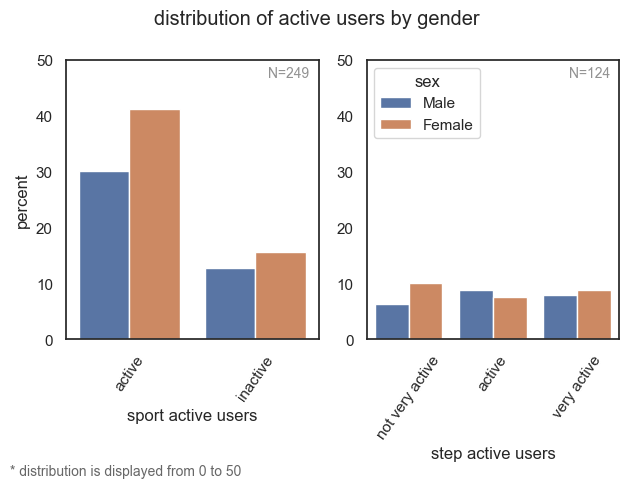

In [78]:
# analysis by sex
fig, axs = plt.subplots(1, 2)

sns.countplot(data=complete_dataset, x="sport activity", hue="w1_A01", stat="percent", ax=axs[0], legend=False)
axs[0].set_yticks(range(0, 51, 10))
axs[0].set_xlabel("sport active users")
axs[0].tick_params(axis='x', rotation=55)
axs[0].text(x=1.1, y=47.0, s=f"N={complete_dataset.shape[0]}", alpha=0.5, fontsize='small')

sns.countplot(data=complete_dataset, x="step activity", hue="w1_A01", stat="percent", ax=axs[1])
axs[1].set_yticks(range(0, 51, 10))
axs[1].set_ylabel("")
axs[1].set_xlabel("step active users")
axs[1].tick_params(axis='x', rotation=55)
axs[1].legend(title='sex', loc='upper left')
axs[1].text(x=1.9, y=47.0, s=f"N={step_validusers.shape[0]}", alpha=0.5, fontsize='small')

plt.suptitle('distribution of active users by gender')
plt.figtext(x=0.02, y=0.01, s="* distribution is displayed from 0 to 50",
            alpha=0.7, fontsize='small')

plt.tight_layout()
plt.show()

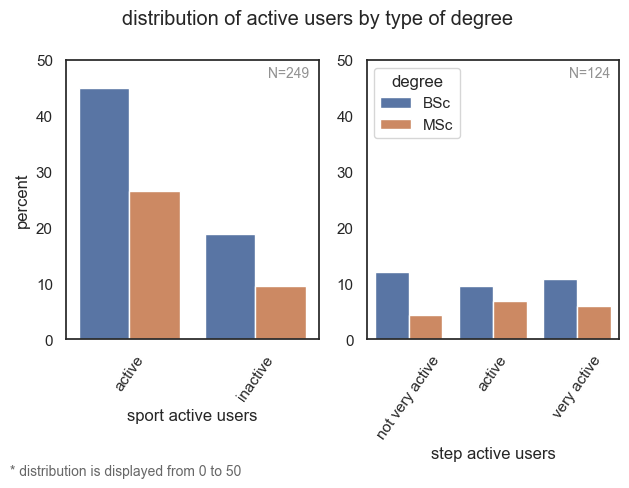

In [79]:
# analysis by degree
fig, axs = plt.subplots(1, 2)

sns.countplot(data=complete_dataset, x="sport activity", hue="degree", stat="percent", ax=axs[0], legend=False)
axs[0].set_yticks(range(0, 51, 10))
axs[0].set_xlabel("sport active users")
axs[0].tick_params(axis='x', rotation=55)
axs[0].text(x=1.1, y=47.0, s=f"N={complete_dataset.shape[0]}", alpha=0.5, fontsize='small')

sns.countplot(data=complete_dataset, x="step activity", hue="degree", stat="percent", ax=axs[1])
axs[1].set_yticks(range(0, 51, 10))
axs[1].set_ylabel("")
axs[1].set_xlabel("step active users")
axs[1].tick_params(axis='x', rotation=55)
axs[1].legend(title='degree', loc='upper left')
axs[1].text(x=1.9, y=47.0, s=f"N={step_validusers.shape[0]}", alpha=0.5, fontsize='small')

plt.suptitle('distribution of active users by type of degree')
plt.figtext(x=0.02, y=0.01, s="* distribution is displayed from 0 to 50",
            alpha=0.7, fontsize='small')
plt.tight_layout()
plt.show()

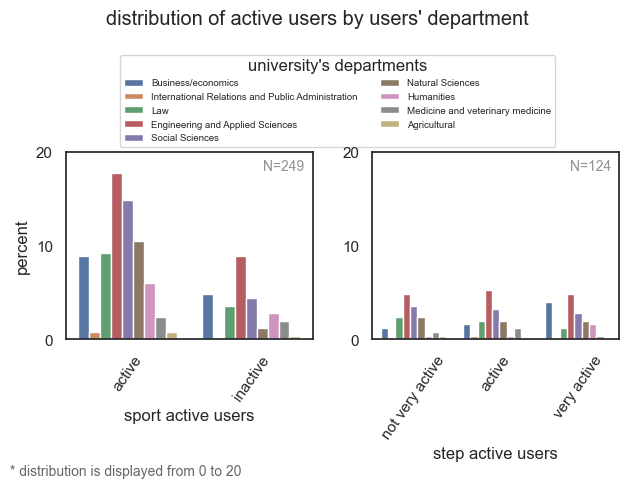

In [80]:
# analysis by department
fig, axs = plt.subplots(1, 2)

sns.countplot(data=complete_dataset, x="sport activity", hue="department", stat="percent", ax=axs[0])
axs[0].set_yticks(range(0, 21, 10))
axs[0].set_xlabel("sport active users")
axs[0].tick_params(axis='x', rotation=55)
axs[0].legend(title="university's departments", fontsize='xx-small', loc='lower left', bbox_to_anchor=(0.2, 1.0, 1.8, 0.2), mode='expand', ncol=2)
axs[0].text(x=1.1, y=18.0, s=f"N={complete_dataset.shape[0]}", alpha=0.5, fontsize='small')

sns.countplot(data=complete_dataset, x="step activity", hue="department", stat="percent", ax=axs[1], legend=False)
axs[1].set_yticks(range(0, 21, 10))
axs[1].set_ylabel("")
axs[1].set_xlabel("step active users")
axs[1].tick_params(axis='x', rotation=55)
axs[1].text(x=1.9, y=18.0, s=f"N={step_validusers.shape[0]}", alpha=0.5, fontsize='small')

plt.suptitle("distribution of active users by users' department")
plt.figtext(x=0.02, y=0.01, s="* distribution is displayed from 0 to 20",
            alpha=0.7, fontsize='small')

plt.tight_layout()
plt.show()

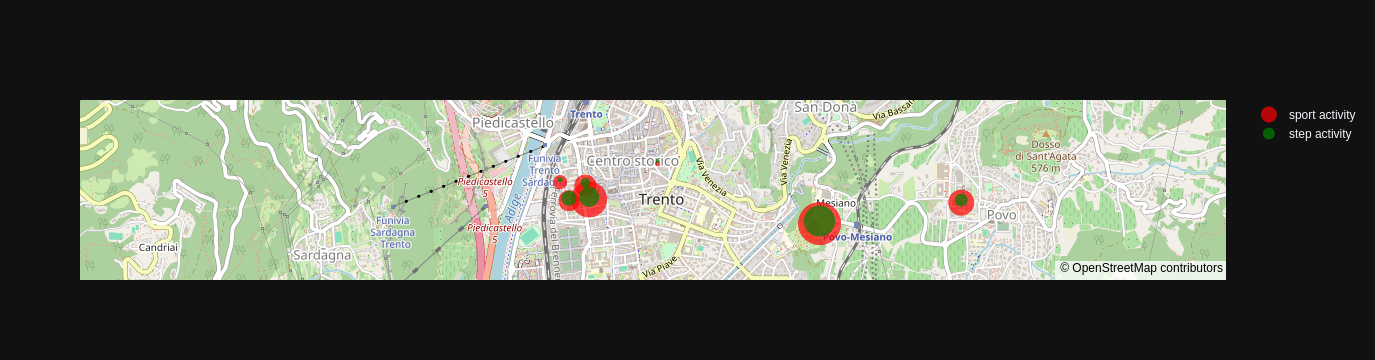

In [81]:
# bubble map for active users distributed in university's departments
# in this case we are comparing step active users (very active and active) with sport active users
# latitude and longitude of university's faculties from google maps
faculties = ['Engineering and Applied Sciences', 'Humanities', 'Agricultural', 'Social Sciences', 'Law', 'Medicine and veterinary medicine', 'Business/economics', 'Natural Sciences', 'International Relations and Public Administration']

latitudes = [46.0649994, 46.0674648, 46.1940590, 46.0664403, 46.06726443, 46.0685753, 46.0663587, 46.0662484, 46.0669779]
longitudes = [11.1393019, 11.1170429, 11.1365402, 11.1195159, 11.1191924, 11.1253963, 11.1177899, 11.1514540, 11.1168052]
sport_size = [44, 15, 2, 37, 23, 6, 22, 27, 2] # sport active users divided by faculties
step_size = [32, 6, 0, 21, 11, 5, 16, 14, 1] # step active users divided by faculties

# Bubble map per sport_size
data_sport = dict(
    lat=latitudes,
    lon=longitudes,
    text=faculties,
    name='sport activity',
    marker=dict(
        size = sport_size,
        color = 'red',
        ),
    hovertemplate="<b>Faculty</b>: %{text}<br><b>Sport active users</b>: %{marker.size}<extra></extra>"

)

offset = 0.00015 # offset
# Bubble map per step_size
data_step = dict(
    lat=[lat + offset for lat in latitudes], # we apply a small offset to avoid overlapping circles
    lon=longitudes,
    text=faculties,
    name='step activity',
    marker=dict(
        size = step_size,
        color = 'green',
        ),
    hovertemplate="<b>Faculty</b>: %{text}<br><b>Step active users</b>: %{marker.size}<extra></extra>"
)

fig = go.Figure()

fig.add_trace(go.Scattermapbox(**data_sport))
fig.add_trace(go.Scattermapbox(**data_step))

# plot the bubbles on openstreetmap layout
fig.update_layout(
    mapbox=dict(
        style='open-street-map',
        zoom=13,
        center=dict(lat=46.067, lon=11.125)
    )
)

fig.show()

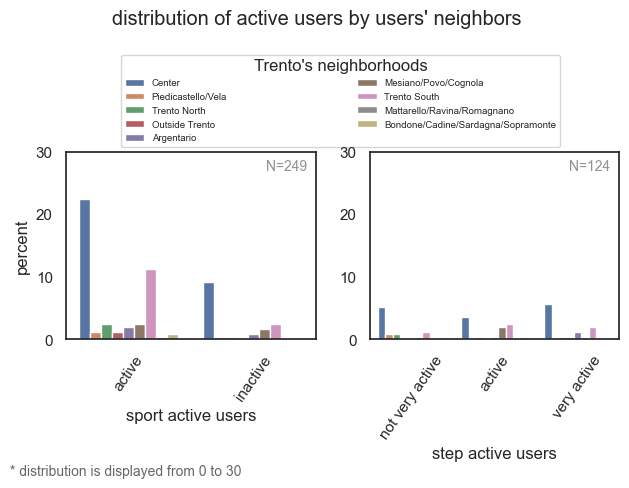

In [82]:
# analysis by city's neighbors
fig, axs = plt.subplots(1, 2)

sns.countplot(data=complete_dataset, x="sport activity", hue="circoscrizioni", stat="percent", ax=axs[0])
axs[0].set_yticks(range(0, 31, 10))
axs[0].set_xlabel("sport active users")
axs[0].tick_params(axis='x', rotation=55)
axs[0].legend(title="Trento's neighborhoods", fontsize='xx-small', loc='lower left', bbox_to_anchor=(0.2, 1.0, 1.8, 0.2), mode='expand', ncol=2)
axs[0].text(x=1.1, y=27.0, s=f"N={complete_dataset.shape[0]}", alpha=0.5, fontsize='small')

sns.countplot(data=complete_dataset, x="step activity", hue="circoscrizioni", stat="percent", ax=axs[1], legend=False)
axs[1].set_yticks(range(0, 31, 10))
axs[1].set_ylabel("")
axs[1].set_xlabel("step active users")
axs[1].tick_params(axis='x', rotation=55)
axs[1].text(x=1.9, y=27.0, s=f"N={step_validusers.shape[0]}", alpha=0.5, fontsize='small')

plt.suptitle("distribution of active users by users' neighbors")
plt.figtext(x=0.02, y=0.01, s="* distribution is displayed from 0 to 30",
            alpha=0.7, fontsize='small')

plt.tight_layout()
plt.show()